In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
%matplotlib inline

from src.utils.make_environment import transition_matrix, insert_walls_into_T
# from src.utils.optimization import soft_q_iteration_torch
from src.utils.inference.likelihood import log_likelihood_torch

In [4]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.make_environment import transition_matrix, Environment, insert_walls_into_T
from src.utils.visualization import plot_posterior_distribution, plot_environment, plot_trajectories, mcmc_diagnostics, plot_log_likelihood
from src.utils.constants import ParamTuple, beta_agent
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories
from src.utils.visualization import plot_log_likelihood

np.set_printoptions(linewidth=160, precision=2)

Create Environment

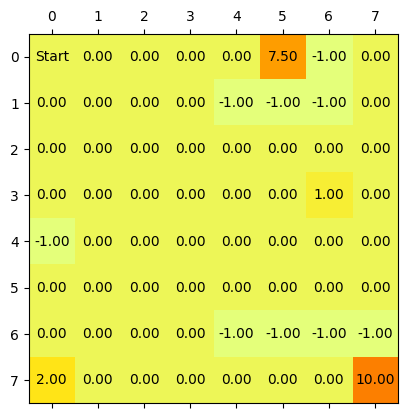

In [5]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 8,8
n_states, n_actions = N * M, 4

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[0, M-3] = 7.5
agent_R[3, M-2] = 1
agent_R[N-1, 0] = 2
agent_R[N-1, M-1] = 10
agent_R[4, 0] = -1

agent_R[1, M-4] = -1
agent_R[1, M-3] = -1
agent_R[1, M-2] = -1
agent_R[0, M-2] = -1

agent_R[N-2, M-4] = -1
agent_R[N-2, M-3] = -1
agent_R[N-2, M-2] = -1
agent_R[N-2, M-1] = -1

plot_environment(
    agent_R.reshape(N, M),
    [])

# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.8
p_true=0.999

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

n_samples_MC = 1_000
n_burnin_MC = 500

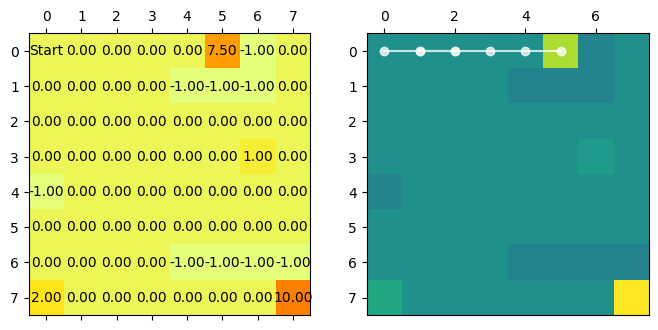

In [6]:
# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_1 = [(env_agent, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7fcd3e1b40d0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 61, in _cb
    callback(self)
  File "/home/paul/.local/lib/python3.10/site-packages/matplotlib/cbook.py", line 248, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'


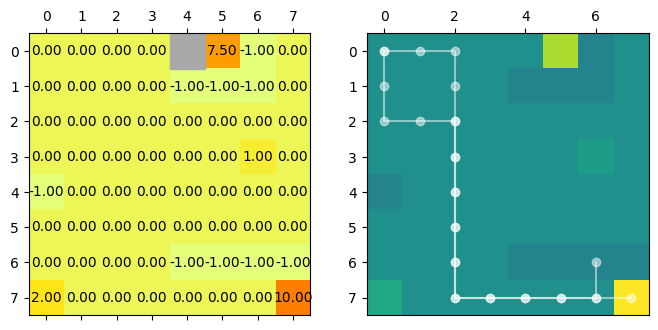

In [7]:
# Generate 2 trajectories in the second round environment
wall_states = [4]


T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
T_true_iteration_2 = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)

'''this is new, we need to add the walls in the environment
#when we do the rollout, otherwise expert behavior makes no sense'''
# T_true_iteration_2 = insert_walls_into_T(T_true_iteration_2, wall_indices=wall_states) 


agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent_2 = Environment(N=N,M=M,T_true=T_true_iteration_2,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories_2 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)
# expert_trajectories = [(env_agent_2, trajectories_2)]
expert_trajectories_2 = expert_trajectories_1
expert_trajectories_2.append([env_agent_2, trajectories_2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_2.wall_states,
    start_state=(0),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_2, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

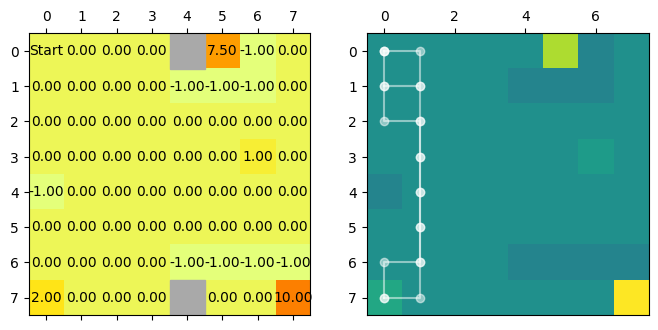

In [8]:
# Generate 2 trajectories in the second round environment
wall_states = [4, (N-1)*M+4]
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)

env_agent_3 = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories_3 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_3 = expert_trajectories_2
expert_trajectories_3.append([env_agent_3, trajectories_3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_3.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_3, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

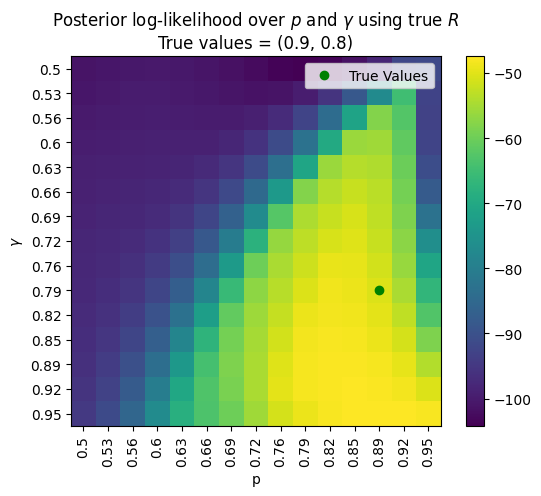

In [9]:
plot_log_likelihood(param_values=true_params, expert_trajectories=expert_trajectories_3, goal_states=goal_states)

In [10]:
def soft_q_iteration_torch(
    R: torch.Tensor,  # R is a one-dimensional tensor with shape (n_states,)
    T_agent: torch.Tensor,
    gamma: float,
    Q_prev: torch.Tensor,
    beta: float,  # Inverse temperature parameter for the softmax function
    tol: float = 1e-1
) -> torch.Tensor:
    n_states, n_actions, _ = T_agent.shape
    V = torch.zeros(n_states, dtype=torch.float64)
    # Q = torch.zeros((n_states, n_actions), dtype=torch.float64)
    Q = Q_prev
    policy = torch.zeros((n_states, n_actions), dtype=torch.float64)

    while True:
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate the Q-value for action a in state s
                Q[s, a] = R[s] + gamma * torch.dot(T_agent[s, a], V)

        # Apply softmax to get a probabilistic policy
        max_Q = torch.max(Q, axis=1, keepdim=True)[0]
        exp_Q = torch.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability
        policy = exp_Q / torch.sum(exp_Q, axis=1, keepdim=True)

        # Calculate the value function V using the probabilistic policy
        V_new = torch.sum(policy * Q.clone(), axis=1) #no idea why we need this clone operation here @Lars
        
        # Check for convergence
        if torch.max(torch.abs(V - V_new)) < tol:
            break

        V = V_new
    return policy, Q

In [11]:
def log_likelihood_torch(T, policy, trajectory):
    log_likelihood = torch.tensor(0.0)
    for s, a, next_s in trajectory[:-1]:
        log_likelihood = log_likelihood + torch.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood

In [12]:
def normalize(val) -> float:
    '''
    normalizes from (-infty, infty) to (0.5, 1)
    '''
    return 0.75 + 0.25*torch.tanh(val)


def log_prob_func(parameter_sample):

    p = normalize(parameter_sample[0])
    gamma = normalize(parameter_sample[1])
    R = parameter_sample[2:]


    log_likelihood = 0.0
    Q_prev = torch.zeros((n_states, n_actions), dtype=torch.float64)

    for env, trajectories in expert_trajectories_1:

        T_agent = transition_matrix(env.N, env.M, p=p, absorbing_states=goal_states)
        T_agent = insert_walls_into_T(T_agent, wall_indices=env.wall_states) #this is new
        T_agent = torch.from_numpy(T_agent).double()
        policy, Q_prev = soft_q_iteration_torch(
            R, T_agent, gamma=gamma, beta=20, Q_prev=Q_prev
        )
        log_likelihood = torch.stack(
            [log_likelihood_torch(env.T_true, policy, traj)
             for traj in trajectories]
        ).sum()
        # for traj in trajectories:
        #     log_likelihood += log_likelihood_torch(env.T_true, policy, traj)
    return log_likelihood
    # return torch.tensor(log_likelihood)

In [20]:
num_samples = 300
step_size = .07
num_steps_per_sample = 3

hamiltorch.set_random_seed(123)
params_init = torch.zeros(N*M+2) + 0.5
params_hmc = hamiltorch.sample(log_prob_func=log_prob_func, params_init=params_init,  step_size=step_size, 
                               num_samples=num_samples, num_steps_per_sample=num_steps_per_sample,
                                debug=1)

Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples | Samples/sec
Step: 0, Current Hamiltoninian: 84.44296061081432, Proposed Hamiltoninian: 84.40231205398212
Accept rho: 0.0
Step: 1, Current Hamiltoninian: 62.36117054397235, Proposed Hamiltoninian: 62.35312514687274
Accept rho: 0.0
0d:00:00:14 | 0d:00:00:00 | #################### | 2/2 | 0.21       
Acceptance Rate 1.00


Save parameters

In [21]:
import pickle

with open("posterior_samples_2_iterations", "wb") as f:
    pickle.dump(params_hmc, f)

In [22]:
with open("posterior_samples_2_iterations", "rb") as fp:   # Unpickling
    b = pickle.load(fp)